0. датафрейм df, колонки "title" - название статьи, "annotation" - аннотация, "text" - текст статьи, "authors" - авторы
1. Векторизация текстов с учётом семантических особенностей
2. Кластеризация (нужны небольшие кластеры)
3. Тестирование: выводим статью, смотрим на те же, что в кластере.

SentenceTransformer - работает с предложениями

In [105]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [107]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

In [109]:
#метрики для оценки качества кластеризации без размеченных данных
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [111]:
df = pd.read_json('it-st-articles-full-PREPROC.json')
df

,year,title,authors,link,annotation,text
0,2025,актуальный задача математический обеспечение с...,"Головин С.А., Лоцманов А.Н., Тихомиров С.Г.",http://itstd-journal.ru/wp-content/uploads/202...,российский союз промышленник предприниматель р...,": ИТ стандартизация, умный (SMART) стандарт, э..."
1,2025,обзор зарубежный международный опыт стандартиз...,Денисова О.А.,http://itstd-journal.ru/wp-content/uploads/202...,мир меняться невероятный темп наблюдать прорыв...,": цифровая трансформация, SMART-стандарты, CEN..."
2,2025,особенность перспектива применение структура п...,"Быковцев Ю.А., Лохин В.М., Манько С.В., Смирно...",http://itstd-journal.ru/wp-content/uploads/202...,модульный подход построение манипуляционный ро...,": модульный манипуляционный робот, динамическа..."
3,2025,подход одноклассовый классификация регулярный ...,Демидов Н.А.,http://itstd-journal.ru/wp-content/uploads/202...,резюме цель статья рассмотреть задача выявлени...,": регулярное выражение, паттерн новизны, BERT,..."
4,2025,унификация описание программный аппаратный мод...,"Кряхтунов Г.М., Боронников А.С., Платонова О.В.",http://itstd-journal.ru/wp-content/uploads/202...,проектирование базис сверхбольшой интегральный...,": описание, программные модели, аппаратные мод..."
...,...,...,...,...,...,...
335,2015,проблема разработка применение российский феде...,Щербина В.И.,http://itstd-journal.ru/wp-content/uploads/201...,,": переводные стандарты, международные стандарт..."
336,2015,опыт интеграция проблема стандартизация распре...,Куделькин В.А.,http://itstd-journal.ru/wp-content/uploads/201...,рассматриваться опыт разработка интегрировать ...,": мониторинг, распределенные системы, интеграц..."
337,2014,путь обеспечение безопасность функционирование...,Петров А.Б.; Андрианова Е.Г.; Сычева А.И.; Баг...,http://itstd-journal.ru/wp-content/uploads/201...,,": безопасность функционирования, информационны..."
338,2014,развитие медицинский информатика новый направл...,Борисова Н.В.; Карачунский А.И.; Старичкова Ю.В.,http://itstd-journal.ru/wp-content/uploads/201...,,": медицинская информатика, здравоохранение, ин..."


In [113]:
tqdm.pandas() #применяем прогресс-бар для пандаса

### 1. SentenceTransformer

In [118]:
model = SentenceTransformer('all-MiniLM-L6-v2') #предобученная модель

df['text_embedding'] = df['text'].progress_apply(lambda x: model.encode(x)) #векторизация

100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [00:52<00:00,  6.42it/s]


In [120]:
embeddings = np.array(df['text_embedding'].tolist()) #эмбеддинги в массив

#### 1.1 Agglomerative clustering

In [123]:
n_clusters = len(df) // 8 #будем стремиться к 8 статьям в одном кластере, примерно прикинем сколько это кластеров
print(f"Количество кластеров: {n_clusters}")

#можно брать от 250 до 300
#интересует сколько одиночных статей и метрики

Количество кластеров: 42


In [125]:
clustering = AgglomerativeClustering(n_clusters=n_clusters,linkage='average')
df['cluster'] = clustering.fit_predict(embeddings)

In [127]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes

cluster
0     134
32     30
27     21
8      18
16     13
4      13
3       9
10      9
19      9
7       6
13      5
18      5
33      4
2       4
15      4
23      4
1       3
11      3
17      3
20      3
25      3
38      3
5       3
14      3
26      3
9       3
28      2
34      2
22      2
12      2
40      2
6       2
24      1
37      1
29      1
39      1
21      1
41      1
30      1
31      1
35      1
36      1
Name: count, dtype: int64

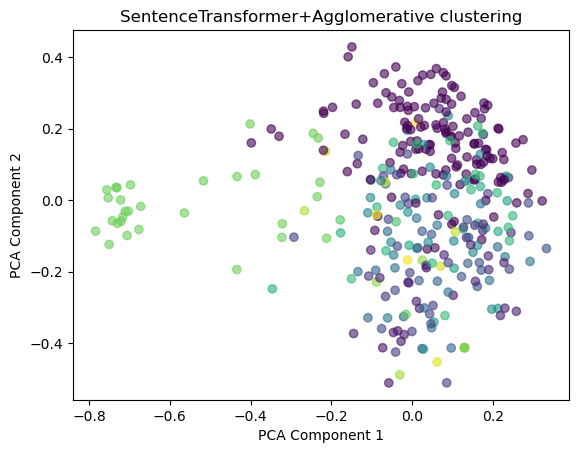

In [129]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SentenceTransformer+Agglomerative clustering')

plt.show()

На картинке даже два кластера не выделяется. 

In [134]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(14)

Title: построение система агрегирование информация
Authors: Васюков А.Е.; Крюков Д.А.
Annotation: рассмотреть подход построение система агрегирование информация контекст архитектура клиент сервер цель поиск наиболее эффективный конфигурация система предложить имитационный модель система агрегирование информация основа получить имитационный модель собрать экспериментальный дать построить математический модель система
Text: : горизонтально масштабируемая система, система агрегирования информации, имитационное моделирование...
--------------------------------------------------------------------------------
Title: сравнительный анализ алгоритм балансировка нагрузка вычислительный кластер
Authors: Крюков Д.А.; Суглобов Д.С.
Annotation: эффективность функционирование кластер зависеть модуль балансировка нагрузка именно применять немой алгоритм балансировка нагрузка статья провести анализ базовый алгоритм балансировка позиция влияние скорость обработка запрос вычислительный кластер анализ исп

По-моему, статьи никак не связаны.

In [136]:
import random

random_index = random.randint(0, len(df) - 1) #случайно статью выберем
random_article = df.iloc[random_index]

print(f"Title: {random_article['title']}")
print(f"Authors: {random_article['authors']}")
print(f"Annotation: {random_article['annotation']}")
print(f"Text: {random_article['text'][:500]}...")  # Выводим первые 500 символов текста

cluster_id = random_article['cluster'] #статьи из того же кластера
cluster_articles = df[df['cluster'] == cluster_id]

print("\nСтатьи из того же кластера:")
for _, article in cluster_articles.iterrows():
    print(f"Title: {article['title']}, Authors: {article['authors']}")

Title: алгоритмический обеспечение моделирование перколяционный процесс случайный сетевой структура
Authors: Зальцман А.Д.
Annotation: исследование процесс распространение информация кластеризация узел сеть социальный связь иметь случайный топология являться очень актуальный задача экономика реклама маркетинг социология политология далее работа рассматриваться вопрос разработка алгоритм построение сетевой структура иметь случайный строение алгоритм исследование перколяционный процесс необходимо ответ вопрос влиять средний число связь величина порог перколяция ряд важный процесс
Text: : кластеризация узлов, случайная топология, алгоритмы построения случайных сетей, перколяционные процессы, порог перколяции ALGORITHMIC MEANS OF PERCOLATIVE PROCESSES MODELLING IN RANDOM NETWORK STRUCTURES 1Zaltsman A. MIREA (Federal State Budget Educational Institution of Higher Education “Moscow Technological University”), 119454, 78 Prospekt Vernadskovo st., Moscow, Russia, ad.zaltcman@gmail.com Researc

Если оценивать субъективно, попаданий, скорее, нет. Попробуем прогнать через цикл и посмотреть результат с разным количеством кластеров.

In [138]:
#пробую автоматизированно прогнать в цикле и получить метрики для разного количества кластеров

max_clust_list = []
min_clust_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(2, 200, 2) 

for n_clusters in n_clusters_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    df['cluster'] = clustering.fit_predict(embeddings)
    
    cluster_sizes = df['cluster'].value_counts()
    
    max_clust_list.append(cluster_sizes.max())  
    min_clust_list.append(cluster_sizes[cluster_sizes.isin([1, 2])].count())  
    Silhouett.append(silhouette_score(embeddings, df['cluster']))  
    Calinski_Harabas.append(calinski_harabasz_score(embeddings, df['cluster']))  
    Davies_Bouldin.append(davies_bouldin_score(embeddings, df['cluster'])) 

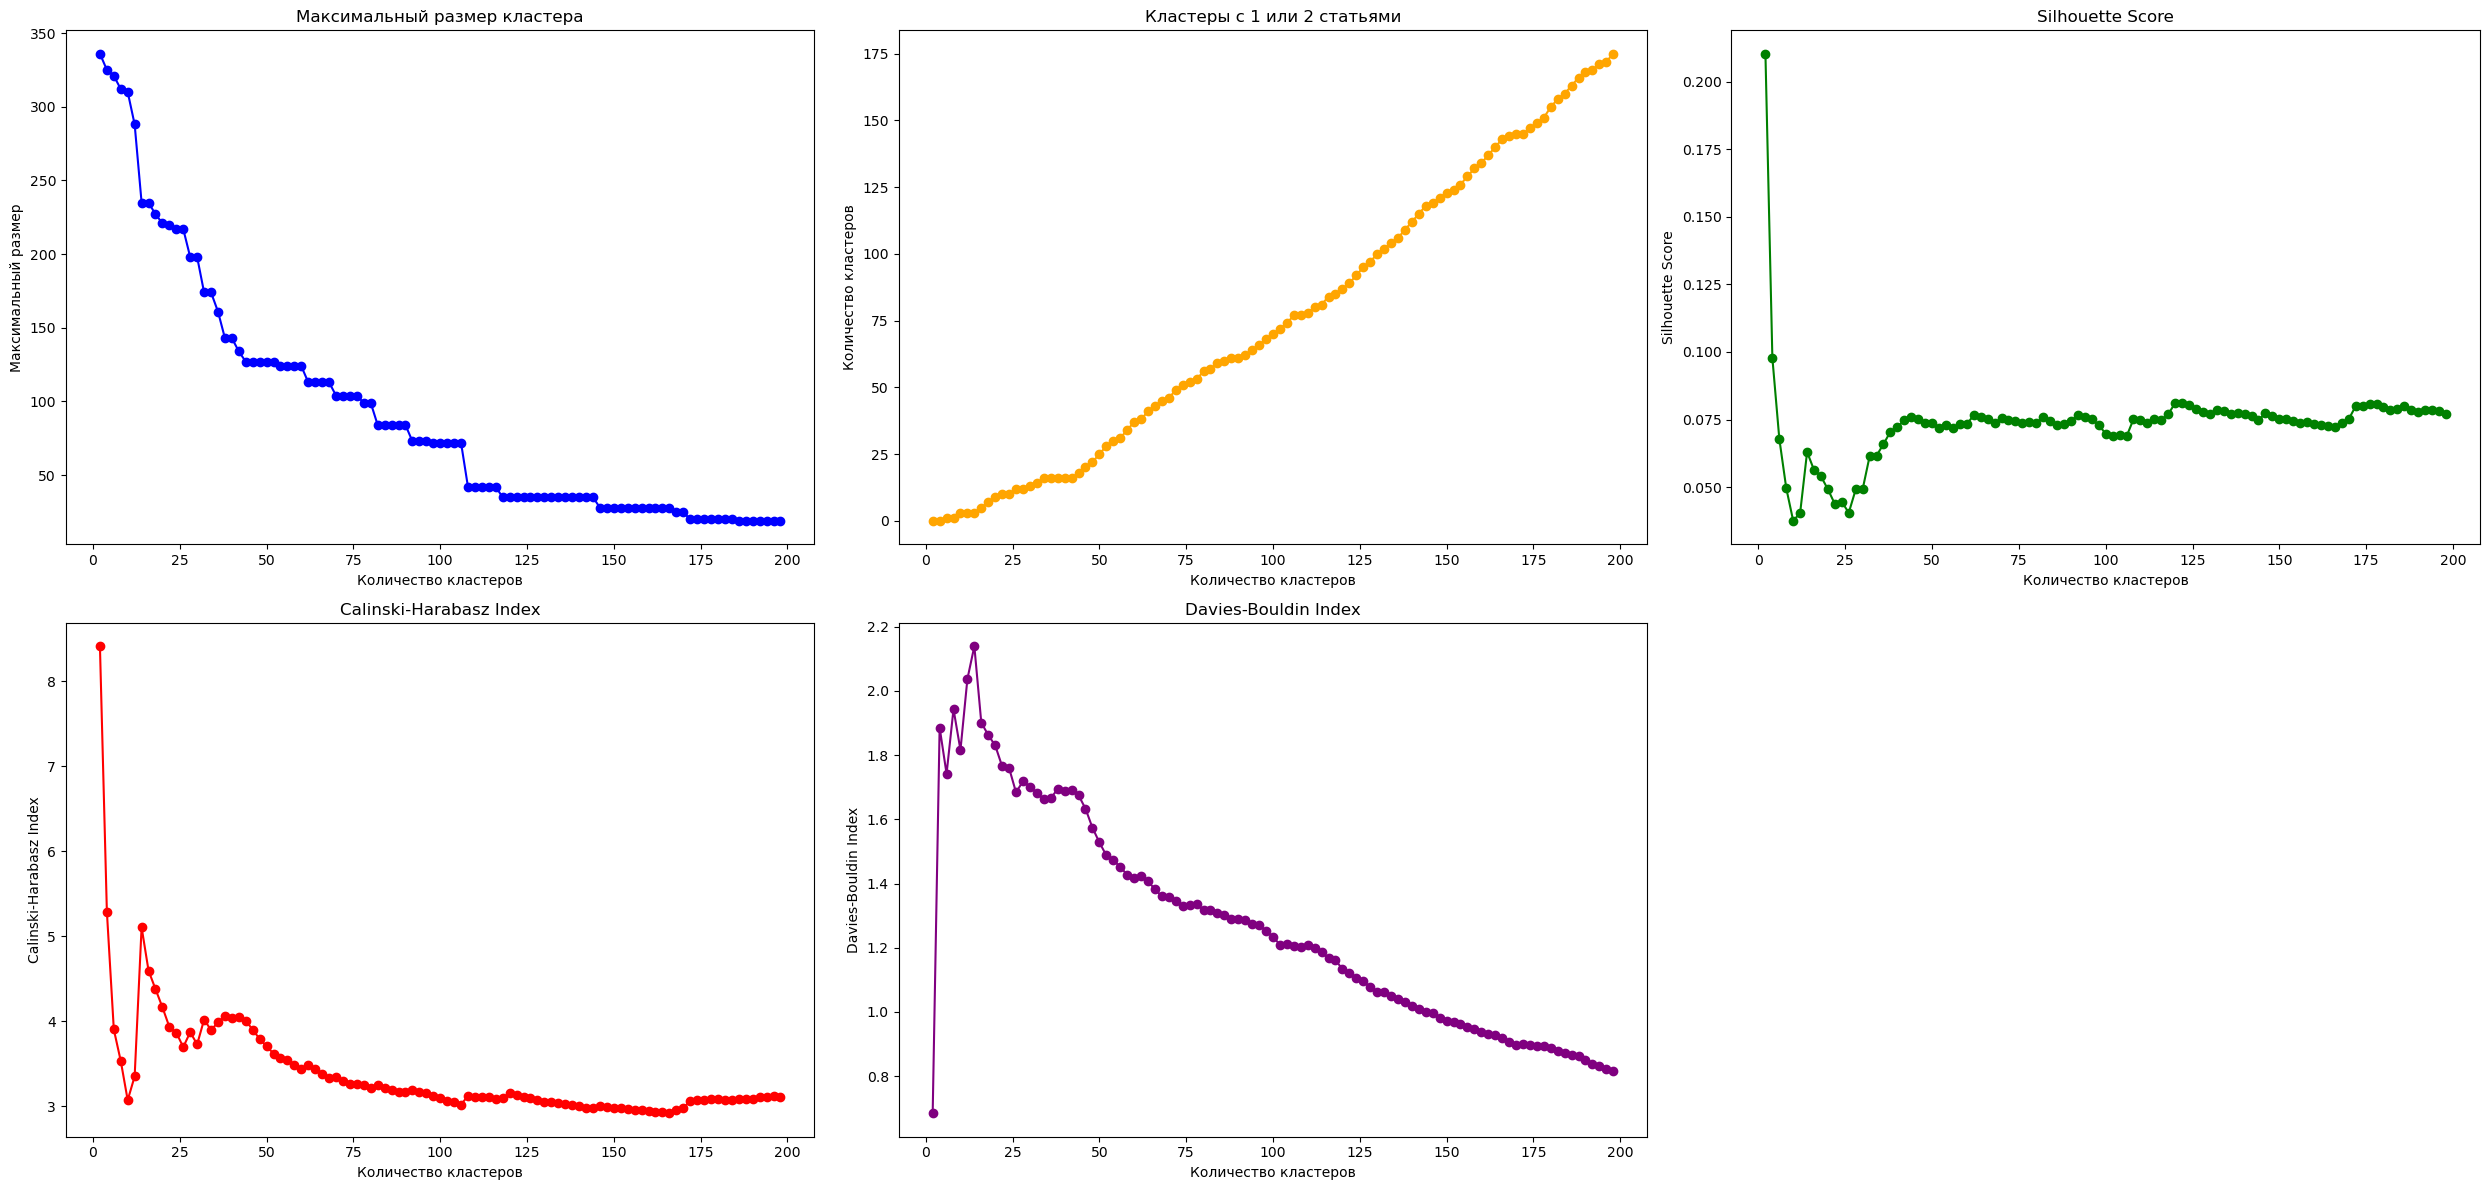

In [139]:
plt.figure(figsize=(25, 12))  

plt.subplot(2, 3, 1)  
plt.plot(n_clusters_range, max_clust_list, marker='o', color='blue')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 2)  
plt.plot(n_clusters_range, min_clust_list, marker='o', color='orange')
plt.title('Кластеры с 1 или 2 статьями')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4) 
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)  
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

#### 1.2 DBSCAN

In [143]:
eps = 0.05 #максимальное расстояние между двумя образцами для того, чтобы они считались соседями
min_samples = 2  #минимальное количество образцов в окрестности точки, чтобы она считалась ядром

clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
df['cluster'] = clustering.fit_predict(embeddings)

cluster_sizes = df['cluster'].value_counts()
print("Размеры кластеров:")
print(cluster_sizes)

if -1 in cluster_sizes:
    print(f"Количество статей, не попавших в кластеры (шум): {cluster_sizes[-1]}")

Размеры кластеров:
cluster
-1    332
 2      4
 0      2
 1      2
Name: count, dtype: int64
Количество статей, не попавших в кластеры (шум): 332


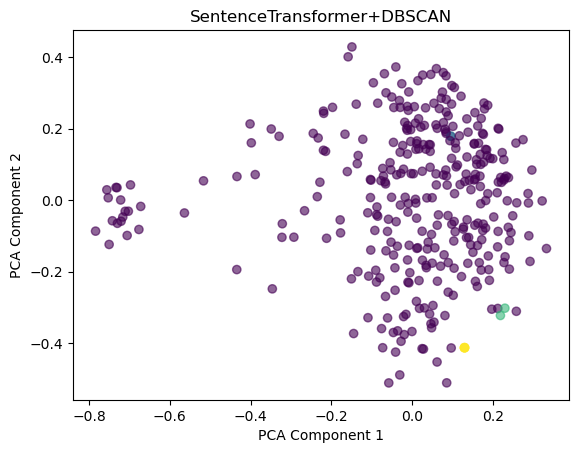

In [145]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SentenceTransformer+DBSCAN')

plt.show()

In [147]:
#прогоняю в цикле и получаю метрики для разных параметров модели
eps_list = []
min_samples_list = []
n_clusters_list = []
n_noise_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

eps_range = np.linspace(0.1, 1.0, 10)  
min_samples_range = range(2, 11)  


for eps in eps_range:
    for min_samples in min_samples_range:
        
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        df['cluster'] = clustering.fit_predict(embeddings)
        
        n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
    
        n_noise = list(df['cluster']).count(-1) #количество шума
        
        eps_list.append(eps)
        min_samples_list.append(min_samples)
        n_clusters_list.append(n_clusters)
        n_noise_list.append(n_noise)
        
        if n_clusters > 1:
            Silhouett.append(silhouette_score(embeddings, df['cluster']))
            Calinski_Harabas.append(calinski_harabasz_score(embeddings, df['cluster']))
            Davies_Bouldin.append(davies_bouldin_score(embeddings, df['cluster']))
        else:
            Silhouett.append(np.nan) 
            Calinski_Harabas.append(np.nan)
            Davies_Bouldin.append(np.nan)

In [149]:
eps_list = np.array(eps_list)
min_samples_list = np.array(min_samples_list)
n_clusters_list = np.array(n_clusters_list)
n_noise_list = np.array(n_noise_list)
Silhouett = np.array(Silhouett)
Calinski_Harabas = np.array(Calinski_Harabas)
Davies_Bouldin = np.array(Davies_Bouldin)

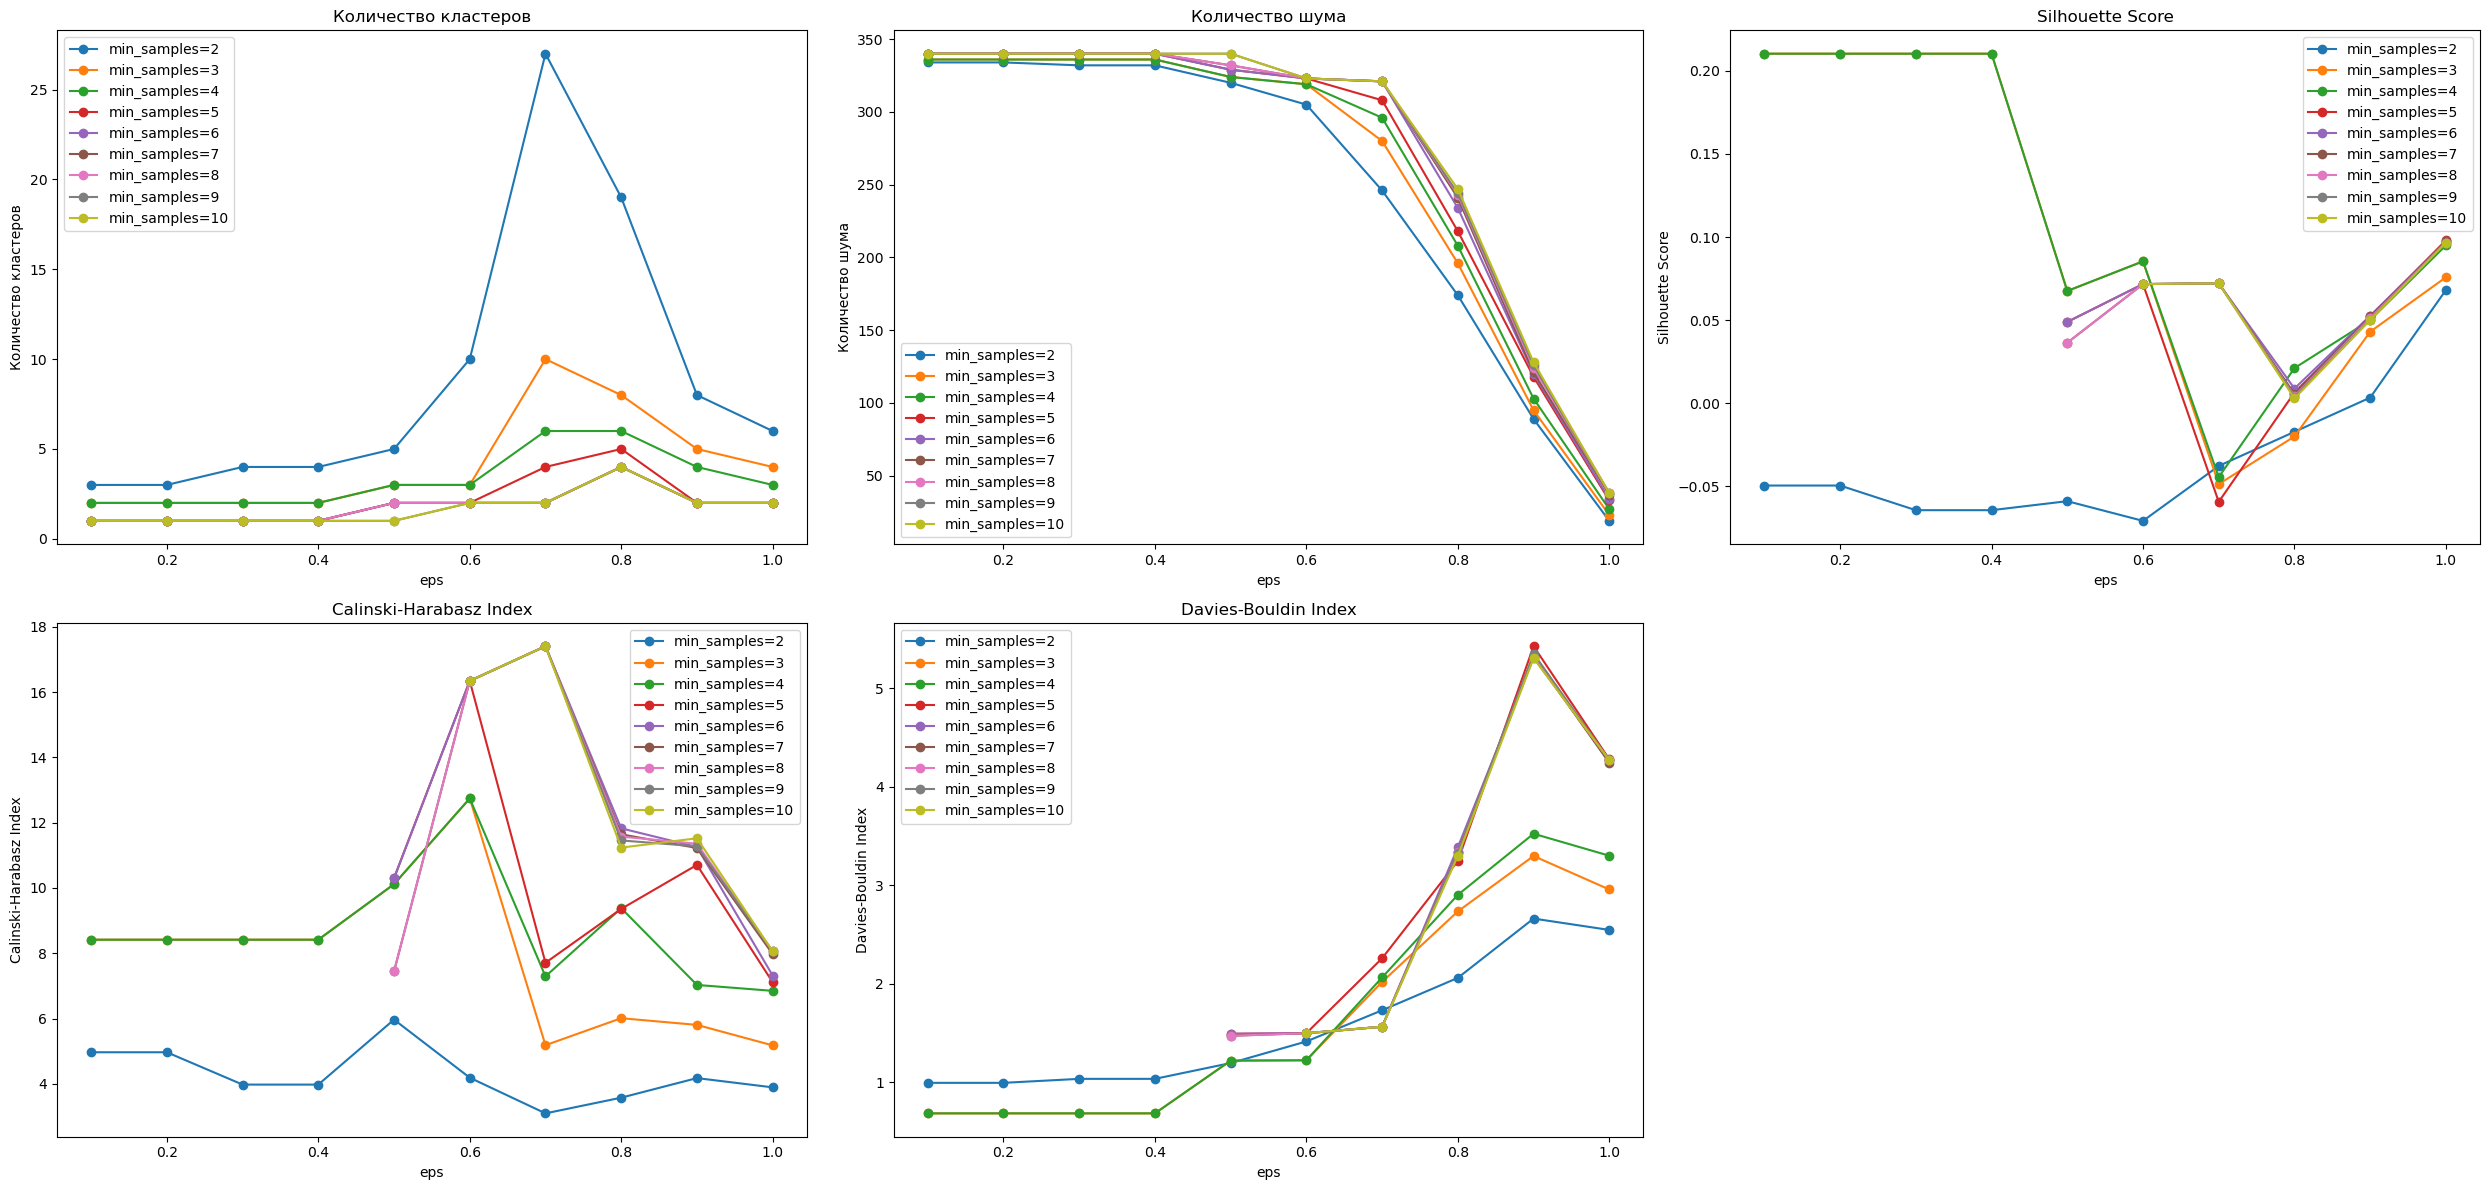

In [151]:
plt.figure(figsize=(25, 12))  

plt.subplot(2, 3, 1)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], n_clusters_list[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Количество кластеров')
plt.xlabel('eps')
plt.ylabel('Количество кластеров')
plt.legend()

plt.subplot(2, 3, 2) 
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], n_noise_list[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Количество шума')
plt.xlabel('eps')
plt.ylabel('Количество шума')
plt.legend()

plt.subplot(2, 3, 3)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], Silhouett[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Silhouette Score')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.legend()

plt.subplot(2, 3, 4)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], Calinski_Harabas[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Calinski-Harabasz Index')
plt.xlabel('eps')
plt.ylabel('Calinski-Harabasz Index')
plt.legend()

plt.subplot(2, 3, 5)  
for min_samples in min_samples_range:
    mask = min_samples_list == min_samples
    plt.plot(eps_list[mask], Davies_Bouldin[mask], marker='o', label=f'min_samples={min_samples}')
plt.title('Davies-Bouldin Index')
plt.xlabel('eps')
plt.ylabel('Davies-Bouldin Index')
plt.legend()

plt.tight_layout()
plt.show()

В DBSCAN как ни крути параметры, всё равно либо очень много шума, либо очень много статей в одном кластере. В плане сглаженности размеров кластеров аггломеративная лучше была.

#### 1.3 K-means

In [155]:
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

cluster_sizes = df['cluster'].value_counts()
print("Размеры кластеров:")
print(cluster_sizes)

cluster_sizes = df['cluster'].value_counts()

single_item_clusters = (cluster_sizes == 1).sum()

print(f"Количество кластеров с ровно 1 элементом: {single_item_clusters}")

Размеры кластеров:
cluster
3    61
4    59
2    54
8    50
1    45
9    27
5    24
0    10
6     6
7     4
Name: count, dtype: int64
Количество кластеров с ровно 1 элементом: 0


C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


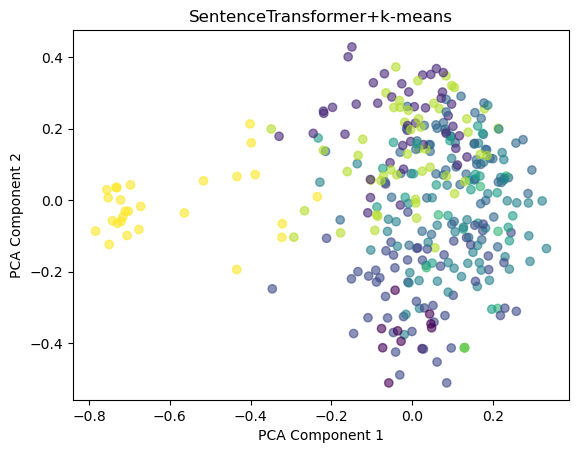

In [157]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure()
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SentenceTransformer+k-means')

plt.show()

In [161]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(6)

Title: подход создание сервис генерация программный код мобильный приложение использование больший языковой модель
Authors: Резуник Л., Александров Д.В.
Annotation: 
Text: : генерация кода, мобильная разработка, большие языковые модели, тонкая настройка, веб- сервис. APPR...
--------------------------------------------------------------------------------
Title: интеграция система необходимый инструмент повышение эффективность бизнес
Authors: Макарова А.С., Полторак А.В.
Annotation: статья привести краткий обзор современный система представлять программный обеспечение управление жизненный цикл изделие система ориентировать взаимодействие клиент предприятие проанализировать возможность особенность система данный класс рассмотреть подход включение система единый информационный пространство информационный система предприятие улучшение эффективность бизнес процесс пример существующий компания предложить способ решение вопрос повышение конкурентоспособность бизнес помощь использование интегр

Сказала бы что всё равно субъективно оценила качество кластеризации как плохое, но лучше чем аггломеративная, и метрики тут тоже получше.

In [163]:
n_clusters_list = []
single_item_clusters_list = []
max_cluster_size_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(10, 100, 10)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(embeddings)
    
    cluster_sizes = df['cluster'].value_counts()
    single_item_clusters = (cluster_sizes == 1).sum()
    max_cluster_size = cluster_sizes.max()
    
    n_clusters_list.append(n_clusters)
    single_item_clusters_list.append(single_item_clusters)
    max_cluster_size_list.append(max_cluster_size)
    Silhouett.append(silhouette_score(embeddings, df['cluster']))
    Calinski_Harabas.append(calinski_harabasz_score(embeddings, df['cluster']))
    Davies_Bouldin.append(davies_bouldin_score(embeddings, df['cluster']))

C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [23]:
for i, n_clusters in enumerate(n_clusters_range): #чтоб посмотреть какие значения хорошо получились
    print(f"Количество кластеров: {n_clusters}")
    print(f"  - Кластеров с 1 элементом: {single_item_clusters_list[i]}")
    print(f"  - Silhouette Score: {Silhouett[i]}")
    print(f"  - Calinski-Harabasz Index: {Calinski_Harabas[i]}")
    print(f"  - Davies-Bouldin Index: {Davies_Bouldin[i]}")
    print("-" * 40)

Количество кластеров: 10
  - Кластеров с 1 элементом: 0
  - Silhouette Score: 0.05316917598247528
  - Calinski-Harabasz Index: 8.764771205254936
  - Davies-Bouldin Index: 2.71063205371532
----------------------------------------
Количество кластеров: 20
  - Кластеров с 1 элементом: 1
  - Silhouette Score: 0.03441225737333298
  - Calinski-Harabasz Index: 5.749035793589996
  - Davies-Bouldin Index: 2.4386600288337106
----------------------------------------
Количество кластеров: 30
  - Кластеров с 1 элементом: 1
  - Silhouette Score: 0.050048828125
  - Calinski-Harabasz Index: 5.099625187370792
  - Davies-Bouldin Index: 2.1172007380417943
----------------------------------------
Количество кластеров: 40
  - Кластеров с 1 элементом: 4
  - Silhouette Score: 0.046821948140859604
  - Calinski-Harabasz Index: 4.44135623205819
  - Davies-Bouldin Index: 1.8309644941846557
----------------------------------------
Количество кластеров: 50
  - Кластеров с 1 элементом: 6
  - Silhouette Score: 0.053

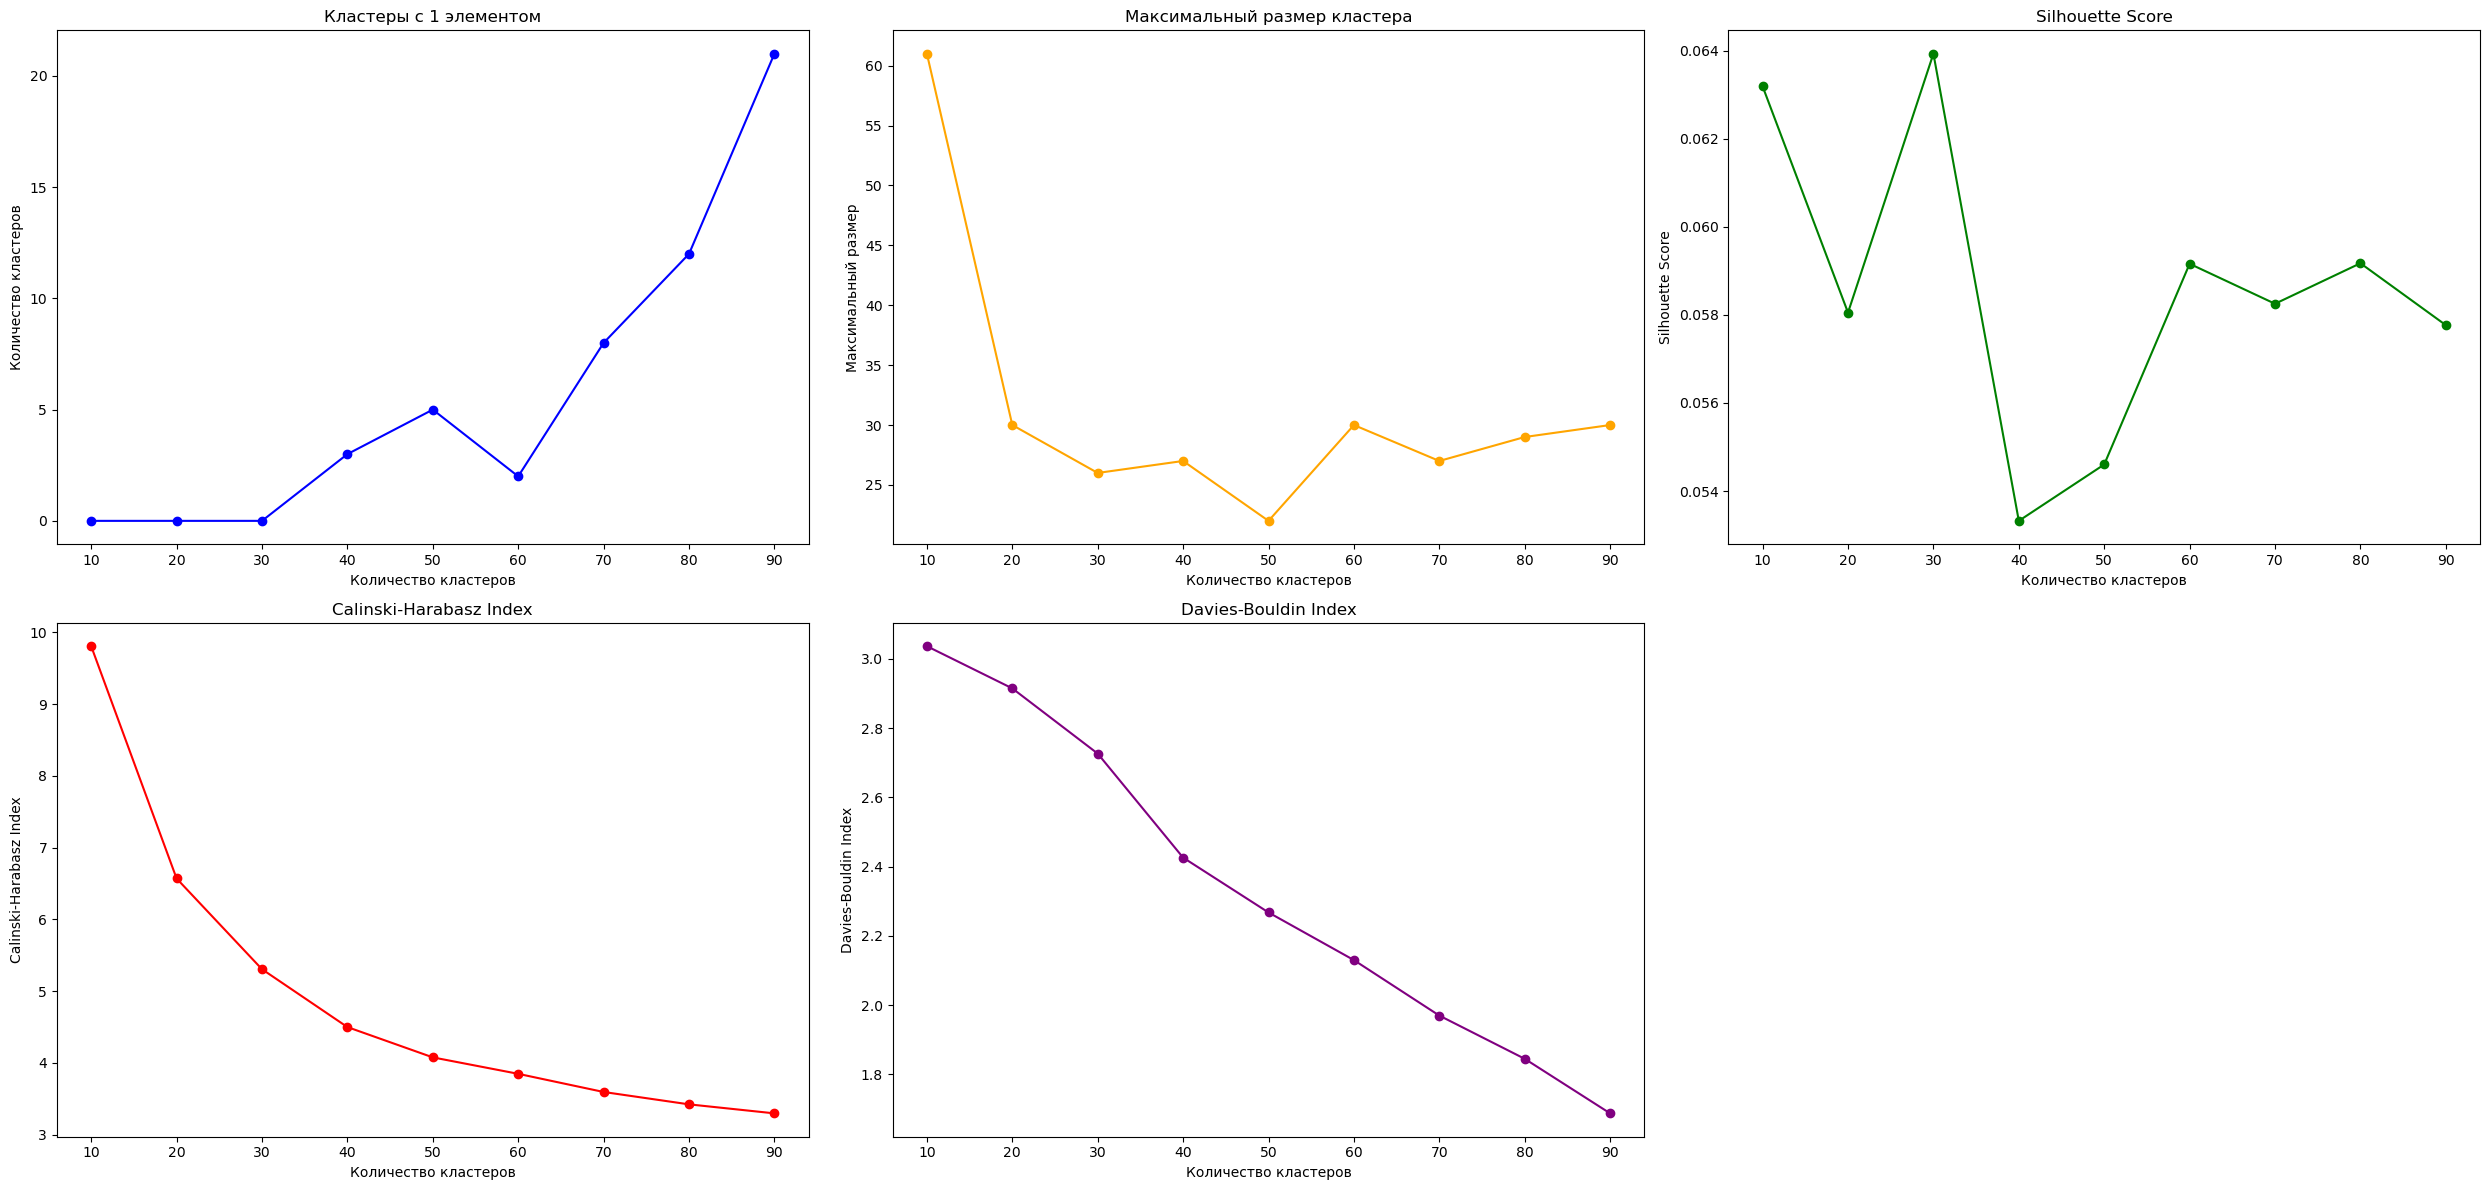

In [165]:
plt.figure(figsize=(25, 12))

plt.subplot(2, 3, 1)
plt.plot(n_clusters_range, single_item_clusters_list, marker='o', color='blue')
plt.title('Кластеры с 1 элементом')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 2)
plt.plot(n_clusters_range, max_cluster_size_list, marker='o', color='orange')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4)
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

Вполне можно использовать 30 кластеров.

### 2. TF-IDF

Смысл текста не сохраняет модель, но попробую.

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [170]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])

In [172]:
X_dense = X.toarray() #для агломеративной преобразуем разреженную матрицу в плотную

In [174]:
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
df['cluster'] = agglo.fit_predict(X_dense)

In [176]:
linked = linkage(X_dense, method='average', metric='cosine') #имеет смысл только на маленьком кусочке данных строить
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индексы статей')
plt.ylabel('Расстояние')
plt.show()

ValueError: The condensed distance matrix must contain only finite values.

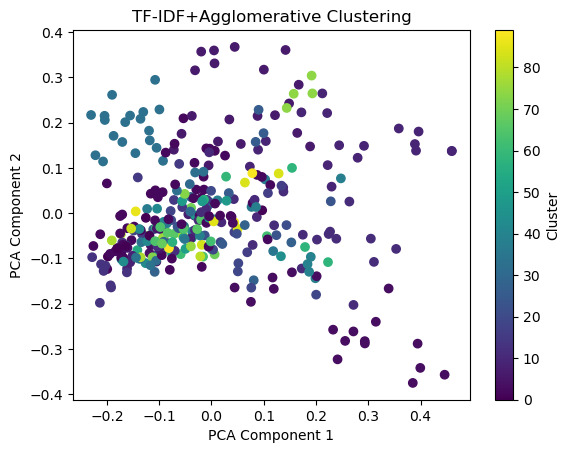

In [178]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('TF-IDF+Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [180]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes

cluster
2     65
33    21
6     20
3     19
11    17
      ..
72     1
65     1
56     1
88     1
68     1
Name: count, Length: 90, dtype: int64

In [184]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:100]}...") 
        print("-" * 80)

show_cluster_articles(10)

Title: организационный подход подготовка обоснование подтверждение результат проект цифровой трансформация машиностроительный предприятие дискретный тип производство
Authors: Прохоров Ю.С.
Annotation: рассматриваться организационный подход подготовка обоснование проект цифровой трансформация машиностроительный предприятие дискретный тип производство путём включение дополнительный этап предпроектный стадия проект сформировать предложение состав информация необходимый принятие управленческий решение старт проект базовый основа информация составлять требование стратегия цифровой трансформация описание бизнес выгода отдельный проект числовой форма совокупный затрата выполнение качество орган принятие решение предложить трехуровневый организационный структура позволять синхронизировать требование стратегия предприятие цель проект предложить точка приложение усилие адаптация организационный культура успешный выполнение проект система ключевой показатель эффективность предложить практико орие

In [188]:
import random

random_index = random.randint(0, len(df) - 1) #случайно статью выберем
random_article = df.iloc[random_index]

print(f"Title: {random_article['title']}")
print(f"Authors: {random_article['authors']}")
print(f"Annotation: {random_article['annotation']}")
print(f"Text: {random_article['text'][:300]}...")  # Выводим первые 500 символов текста

cluster_id = random_article['cluster'] #статьи из того же кластера
cluster_articles = df[df['cluster'] == cluster_id]

print("\nСтатьи из того же кластера:")
for _, article in cluster_articles.iterrows():
    print(f"Title: {article['title']}, Authors: {article['authors']}")

Title: нормализация нормативный технический регулирование посредством цифровизация регулировать документ
Authors: Рагозин О.В.
Annotation: сегодня процесс нормативный технический регулирование различный отрасль экономика россия характеризоваться сложность запутанность норма требование неоднозначность трактовка нормализация указанный процесс предлагаться рассмотреть опыт западный страна выпуск новый либо корректировка существующий нормативный правовой акт стандарт либо организационно распорядительный документ сопровождаться выпуск машиночитаемый версия статья рассматриваться пример применение данный подход создание единый таксономия инцидент цель упорядочивание нормативный требование область безопасность
Text: : нормативно-техническое регулирование, стандарты Semantic Web, RDF, SKOS, таксономия, эталонная модель данных NORMATIVE AND TECHNICAL REGULATION NORMALIZATION THROUGH DIGITALIZATION OF REGULATORY DOCUMENTS Ragozin O.V. Borlas Security Systems LLC, 117105, Russia, Moscow, Novodani

In [190]:
print("Silhouette Score:", silhouette_score(X, df['cluster'])) # (чем ближе к 1, тем лучше)
print("Calinski-Harabasz Index:", calinski_harabasz_score(X.toarray(), df['cluster'])) #чем выше значение, тем лучше
print("Davies-Bouldin Index:", davies_bouldin_score(X.toarray(), df['cluster'])) #чем выше значение, тем лучше

Silhouette Score: 0.05462298627775437
Calinski-Harabasz Index: 1.8429292546153182
Davies-Bouldin Index: 1.7179868547625603


Использование TF-IDF больше похоже на обычный поиск по теме. Можно использовать для начальной кластеризации при более сложной архитектуре (например, сначала отсеиваем совсем неподходящие статьи разбивая датасет на небольшое количество кластеров векторизацией TF-IDF, затем используем интеллектуальную векторизацию с сохранением смысла слов и ищем внутри кластера более релевантные статьи). Но цель работу всё же не поисковик по теме которую легко можно сформулировать глядя на кластер, а в поиске скрытых связей и "взаимодополняющих" друг друга исследователей.

Метрики хуже векторизации с помощью SentenceTransform. Т.к смысл работы это попробовать сохранить семантику текста, не буду дальше крутить TF-IDF, попробую word2vec.

### 3. Word2vec

Так как если обучать модель на маленьких данных, она некорректно работает, использую базу статей с киберленинки, сохраню полученный word2vec и буду использовать для it-standart'а.

In [195]:
import pandas as pd
from gensim.models import Word2Vec
from tqdm import tqdm 
import multiprocessing

In [197]:
print("Загрузка данных...")
file_path = 'it_math_phys_med_lemmatize.xlsx'
df = pd.read_excel(file_path)

Загрузка данных...


In [19]:
sentences = [text.split() for text in tqdm(df['text'], desc="Токенизация текстов")] #разделение текста на токены

Токенизация текстов: 100%|███████████████████████████████████████████████████████| 8567/8567 [00:03<00:00, 2733.36it/s]


In [36]:
#не надо каждый раз обучать, оно уже в файле
vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

Для обучения модели использовала 8000 статей с киберлининки.

In [198]:
word2vec_model = Word2Vec.load('word2vec.model') #загрузка из файла

In [202]:
def text_to_vector(tokens, model): #функция для создания векторного представления текста
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [206]:
file_path = 'it-st-articles-full-PREPROC.json' #снова открываем файл со статьями из ит-стандарта
df = pd.read_json(file_path)

In [210]:
df['tokens'] = df['text'].apply(lambda x: x.split())

In [212]:
X = np.array([text_to_vector(tokens, word2vec_model) for tokens in df['tokens']]) #применение функции к каждому тексту

#### AgglomerativeClustering

In [215]:
agglo = AgglomerativeClustering(n_clusters=10, linkage='average')
df['cluster'] = agglo.fit_predict(X)

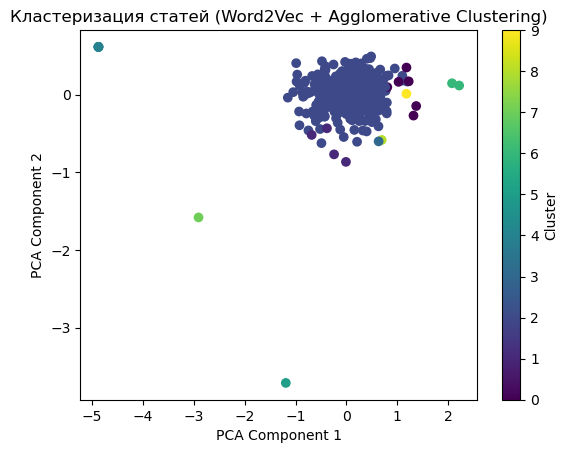

In [217]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Кластеризация статей (Word2Vec + Agglomerative Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [219]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes

cluster
2    319
0      6
1      4
4      4
6      2
7      1
9      1
8      1
5      1
3      1
Name: count, dtype: int64

In [229]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:200]}...")  # Выводим первые 200 символов текста
        print("-" * 80)

# Пример: вывод статей из кластера 0
show_cluster_articles(1)

Title: унификация описание программный аппаратный модель базис сбис
Authors: Кряхтунов Г.М., Боронников А.С., Платонова О.В.
Annotation: проектирование базис сверхбольшой интегральный схема сбис предполагать модульность интеграция библиотека готовый функциональный блок стандартизированный интерфейс статья выдвигаться гипотеза создание унифицировать формат описание аппаратный модель позволить ускорить время разработка тестирование аппаратный решение базис сбис унификация описание аппаратный модель являться важный часть совместимость упрощение разработка тестирование обновление ускорение вывод продукт рынок выявить основной недостаток рассмотреть существующий решение метод определить аспект аппаратный модель пример устройство принимать дать протокол выделить основной функциональный узел аппаратный модель комбинационный схема простой схема память конечный автомат рассмотреть реализация каждый функциональный узел язык описание аппаратура язык программирование высокий уровень представить си

In [231]:
print("Silhouette Score:", silhouette_score(X, df['cluster'])) # (чем ближе к 1, тем лучше)
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, df['cluster'])) #чем выше значение, тем лучше
print("Davies-Bouldin Index:", davies_bouldin_score(X, df['cluster'])) #чем выше значение, тем лучше

Silhouette Score: 0.26218956880885624
Calinski-Harabasz Index: 64.07067661598671
Davies-Bouldin Index: 0.42532104229306666


In [233]:
n_clusters_list = []
single_item_clusters_list = []
max_cluster_size_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(5, 100, 3)

for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    df['cluster'] = agglo.fit_predict(X)
    
    cluster_sizes = df['cluster'].value_counts()
    single_item_clusters = (cluster_sizes == 1).sum()
    max_cluster_size = cluster_sizes.max()
    
    n_clusters_list.append(n_clusters)
    single_item_clusters_list.append(single_item_clusters)
    max_cluster_size_list.append(max_cluster_size)
    Silhouett.append(silhouette_score(X, df['cluster']))
    Calinski_Harabas.append(calinski_harabasz_score(X, df['cluster']))
    Davies_Bouldin.append(davies_bouldin_score(X, df['cluster']))

In [235]:
for i, n_clusters in enumerate(n_clusters_range):
    print(f"Количество кластеров: {n_clusters}")
    print(f"  - Кластеров с 1 элементом: {single_item_clusters_list[i]}")
    print(f"  - Максимальный размер кластера: {max_cluster_size_list[i]}")
    print(f"  - Silhouette Score: {Silhouett[i]}")
    print(f"  - Calinski-Harabasz Index: {Calinski_Harabas[i]}")
    print(f"  - Davies-Bouldin Index: {Davies_Bouldin[i]}")
    print("-" * 40)

Количество кластеров: 5
  - Кластеров с 1 элементом: 2
  - Максимальный размер кластера: 326
  - Silhouette Score: 0.6119555033321781
  - Calinski-Harabasz Index: 120.79286114826827
  - Davies-Bouldin Index: 0.3341126552650488
----------------------------------------
Количество кластеров: 8
  - Кластеров с 1 элементом: 2
  - Максимальный размер кластера: 320
  - Silhouette Score: 0.3829246492719675
  - Calinski-Harabasz Index: 80.93940481560524
  - Davies-Bouldin Index: 0.49490941906031904
----------------------------------------
Количество кластеров: 11
  - Кластеров с 1 элементом: 6
  - Максимальный размер кластера: 319
  - Silhouette Score: 0.25855116332354067
  - Calinski-Harabasz Index: 58.125660927781695
  - Davies-Bouldin Index: 0.4117549983805931
----------------------------------------
Количество кластеров: 14
  - Кластеров с 1 элементом: 6
  - Максимальный размер кластера: 173
  - Silhouette Score: 0.27597030405917733
  - Calinski-Harabasz Index: 117.2430996277418
  - Davies-

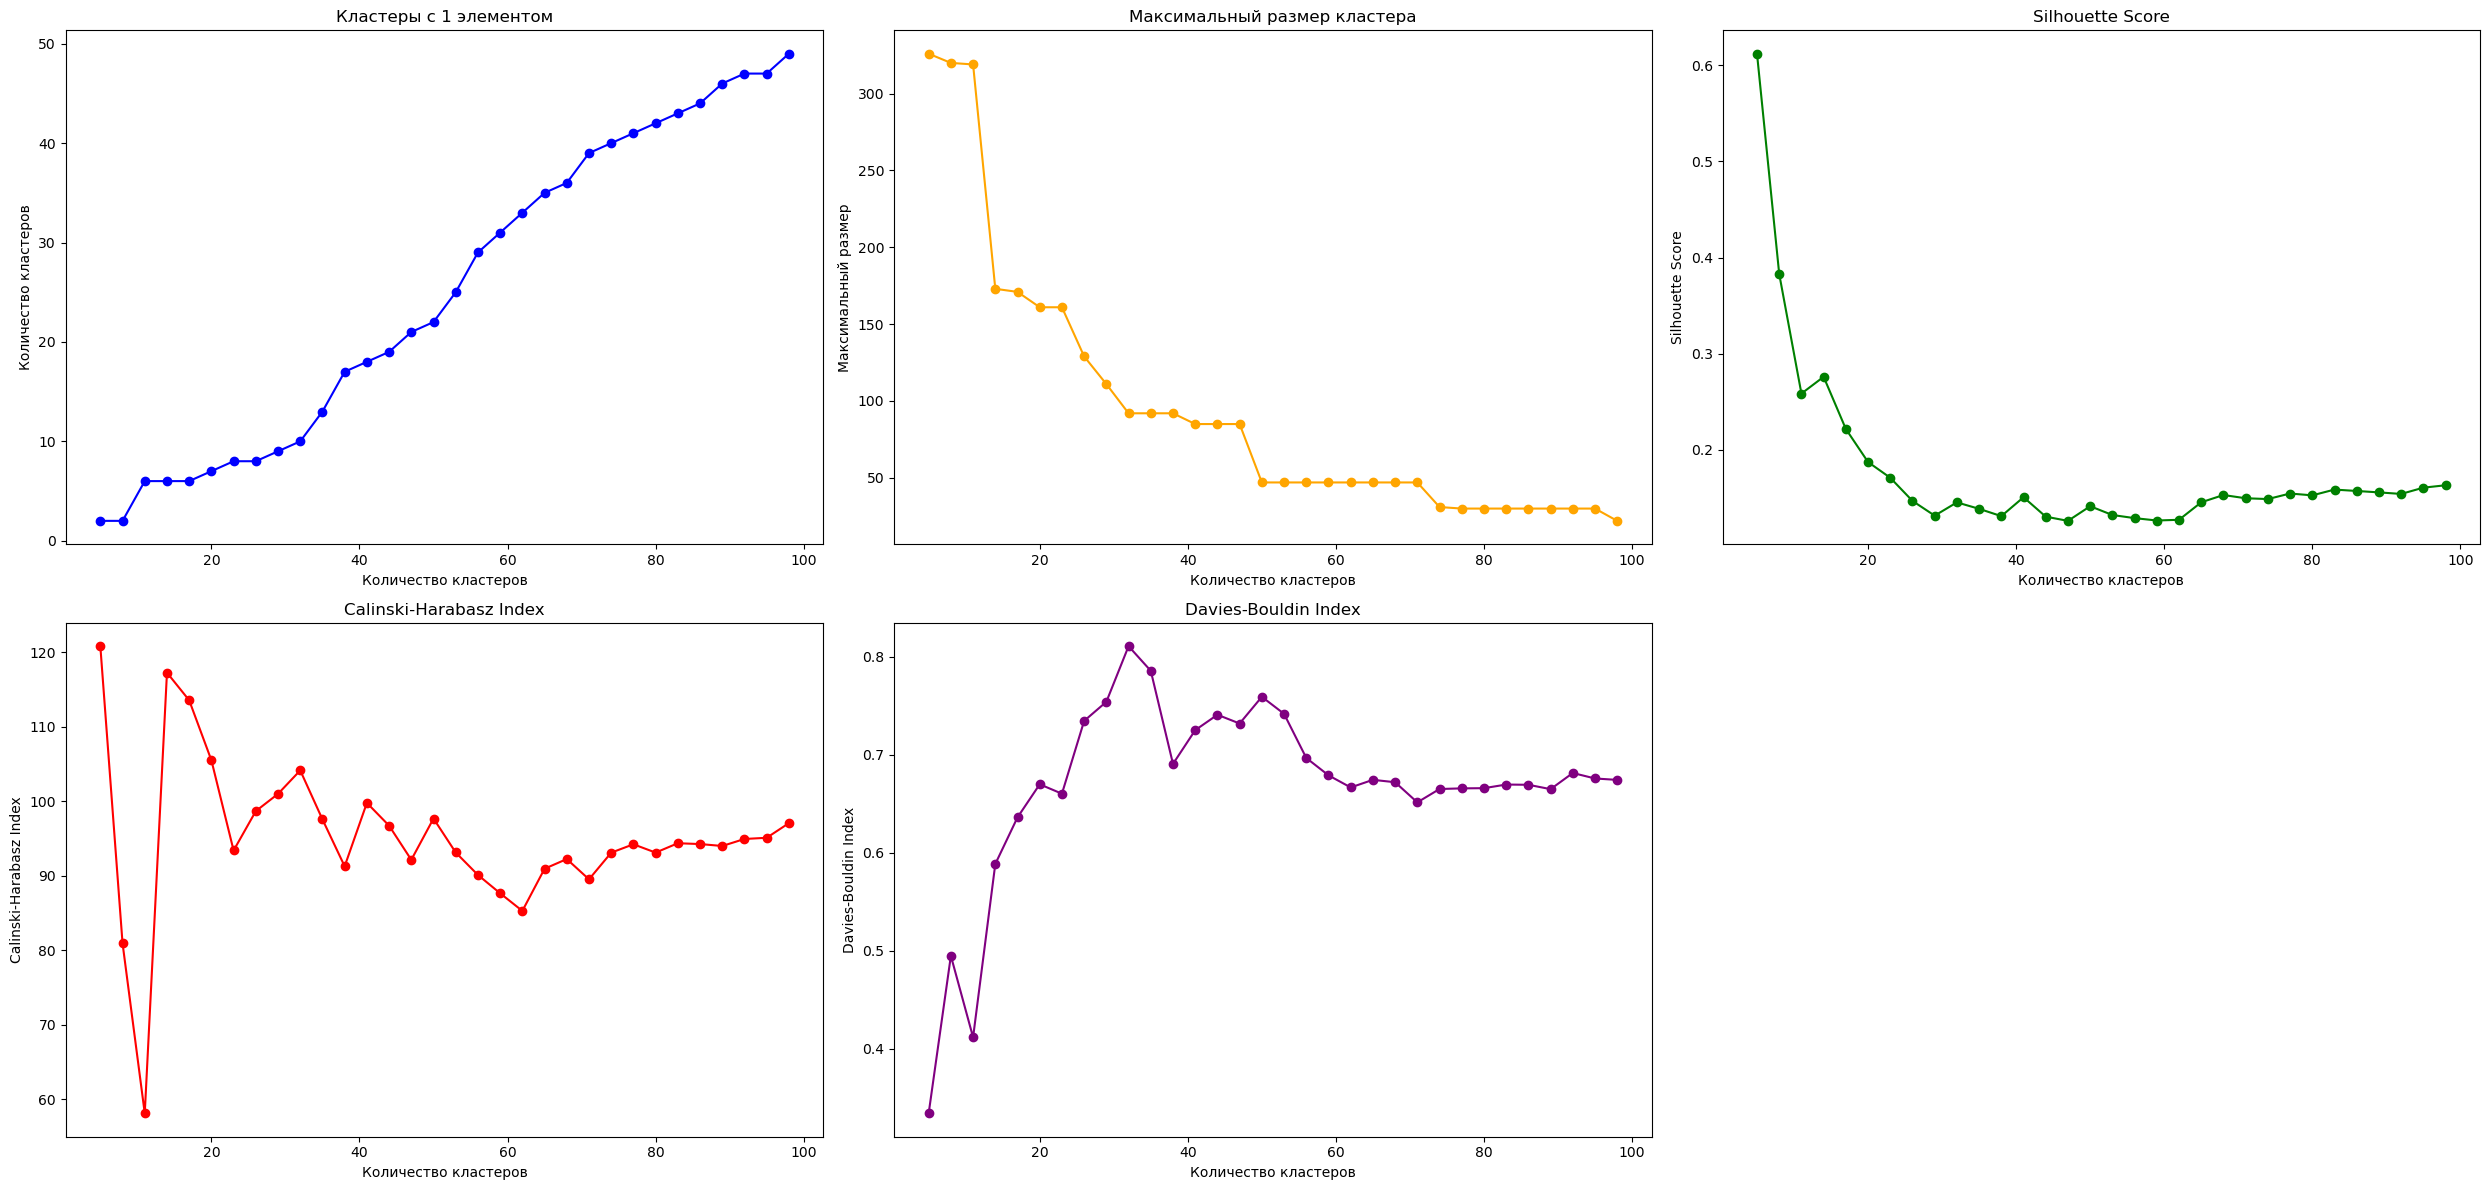

In [237]:
plt.figure(figsize=(25, 12))

plt.subplot(2, 3, 1)
plt.plot(n_clusters_range, single_item_clusters_list, marker='o', color='blue')
plt.title('Кластеры с 1 элементом')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 2)
plt.plot(n_clusters_range, max_cluster_size_list, marker='o', color='orange')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4)
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

#### k-means

In [239]:
kmeans = KMeans(n_clusters=50, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [241]:
cluster_sizes = df['cluster'].value_counts()
cluster_sizes

cluster
5     25
25    18
27    15
39    15
42    14
37    14
24    14
4     14
15    14
0     13
47    12
23    11
30    10
38    10
1      9
10     9
19     7
13     7
49     7
22     7
48     7
11     6
32     6
20     6
7      6
8      5
21     5
31     5
33     4
26     4
35     4
12     4
2      4
28     3
29     3
34     3
44     2
14     2
18     2
43     2
40     2
36     2
17     1
45     1
46     1
9      1
6      1
41     1
16     1
3      1
Name: count, dtype: int64

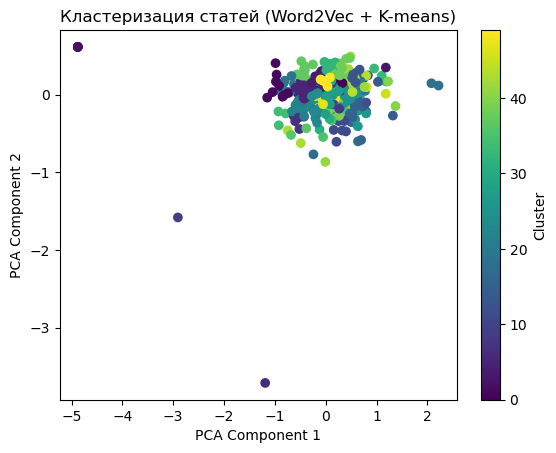

In [243]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Кластеризация статей (Word2Vec + K-means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [253]:
def show_cluster_articles(cluster_id):
    cluster_articles = df[df['cluster'] == cluster_id]
    for idx, row in cluster_articles.iterrows():
        print(f"Title: {row['title']}")
        print(f"Authors: {row['authors']}")
        print(f"Annotation: {row['annotation']}")
        print(f"Text: {row['text'][:200]}...")  # Выводим первые 200 символов текста
        print("-" * 80)

# Пример: вывод статей из кластера 0
show_cluster_articles(28)

Title: современный состояние разработка отечественный стандарт система централизовать наблюдение
Authors: Самышкина Е.В.
Annotation: статья рассмотреть принцип условие направление разработка серия национальный стандарт технический средство модуль использование система централизовать наблюдение
Text: : системы централизованного наблюдения, технические средства и модули, стандартизация CURRENT STATUS OF DEVELOPMENT OF NATIONAL STANDARDS SYSTEM CENTRALIZED MONITORING 1Samyshkina E.V. 1Federal a stat...
--------------------------------------------------------------------------------
Title: анализ направление развитие международный стандартизация область системный программный инженерия
Authors: Костогрызов А.И.
Annotation: 
Text: : анализ, безопасность, качество, риск, системная и программная инженерия, управление Системная инженерия получает сегодня на международном уровне второе дыхание. В некоторых работах 30-40 летней давн...
-------------------------------------------------------------

In [255]:
print("Silhouette Score:", silhouette_score(X, df['cluster']))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, df['cluster']))
print("Davies-Bouldin Index:", davies_bouldin_score(X, df['cluster']))

Silhouette Score: 0.16686083413492256
Calinski-Harabasz Index: 125.37532036138019
Davies-Bouldin Index: 1.0734131334264543


Субъективно оценила бы качество кластеризации как хорошее, метрики выше чем при агломеративной кластеризации.

In [258]:
n_clusters_list = []
single_item_clusters_list = []
max_cluster_size_list = []
Silhouett = []
Calinski_Harabas = []
Davies_Bouldin = []

n_clusters_range = range(10, 100, 5)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)
    
    cluster_sizes = df['cluster'].value_counts()
    single_item_clusters = (cluster_sizes == 1).sum()
    max_cluster_size = cluster_sizes.max()
    
    n_clusters_list.append(n_clusters)
    single_item_clusters_list.append(single_item_clusters)
    max_cluster_size_list.append(max_cluster_size)
    Silhouett.append(silhouette_score(X, df['cluster']))
    Calinski_Harabas.append(calinski_harabasz_score(X, df['cluster']))
    Davies_Bouldin.append(davies_bouldin_score(X, df['cluster']))

C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ksura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

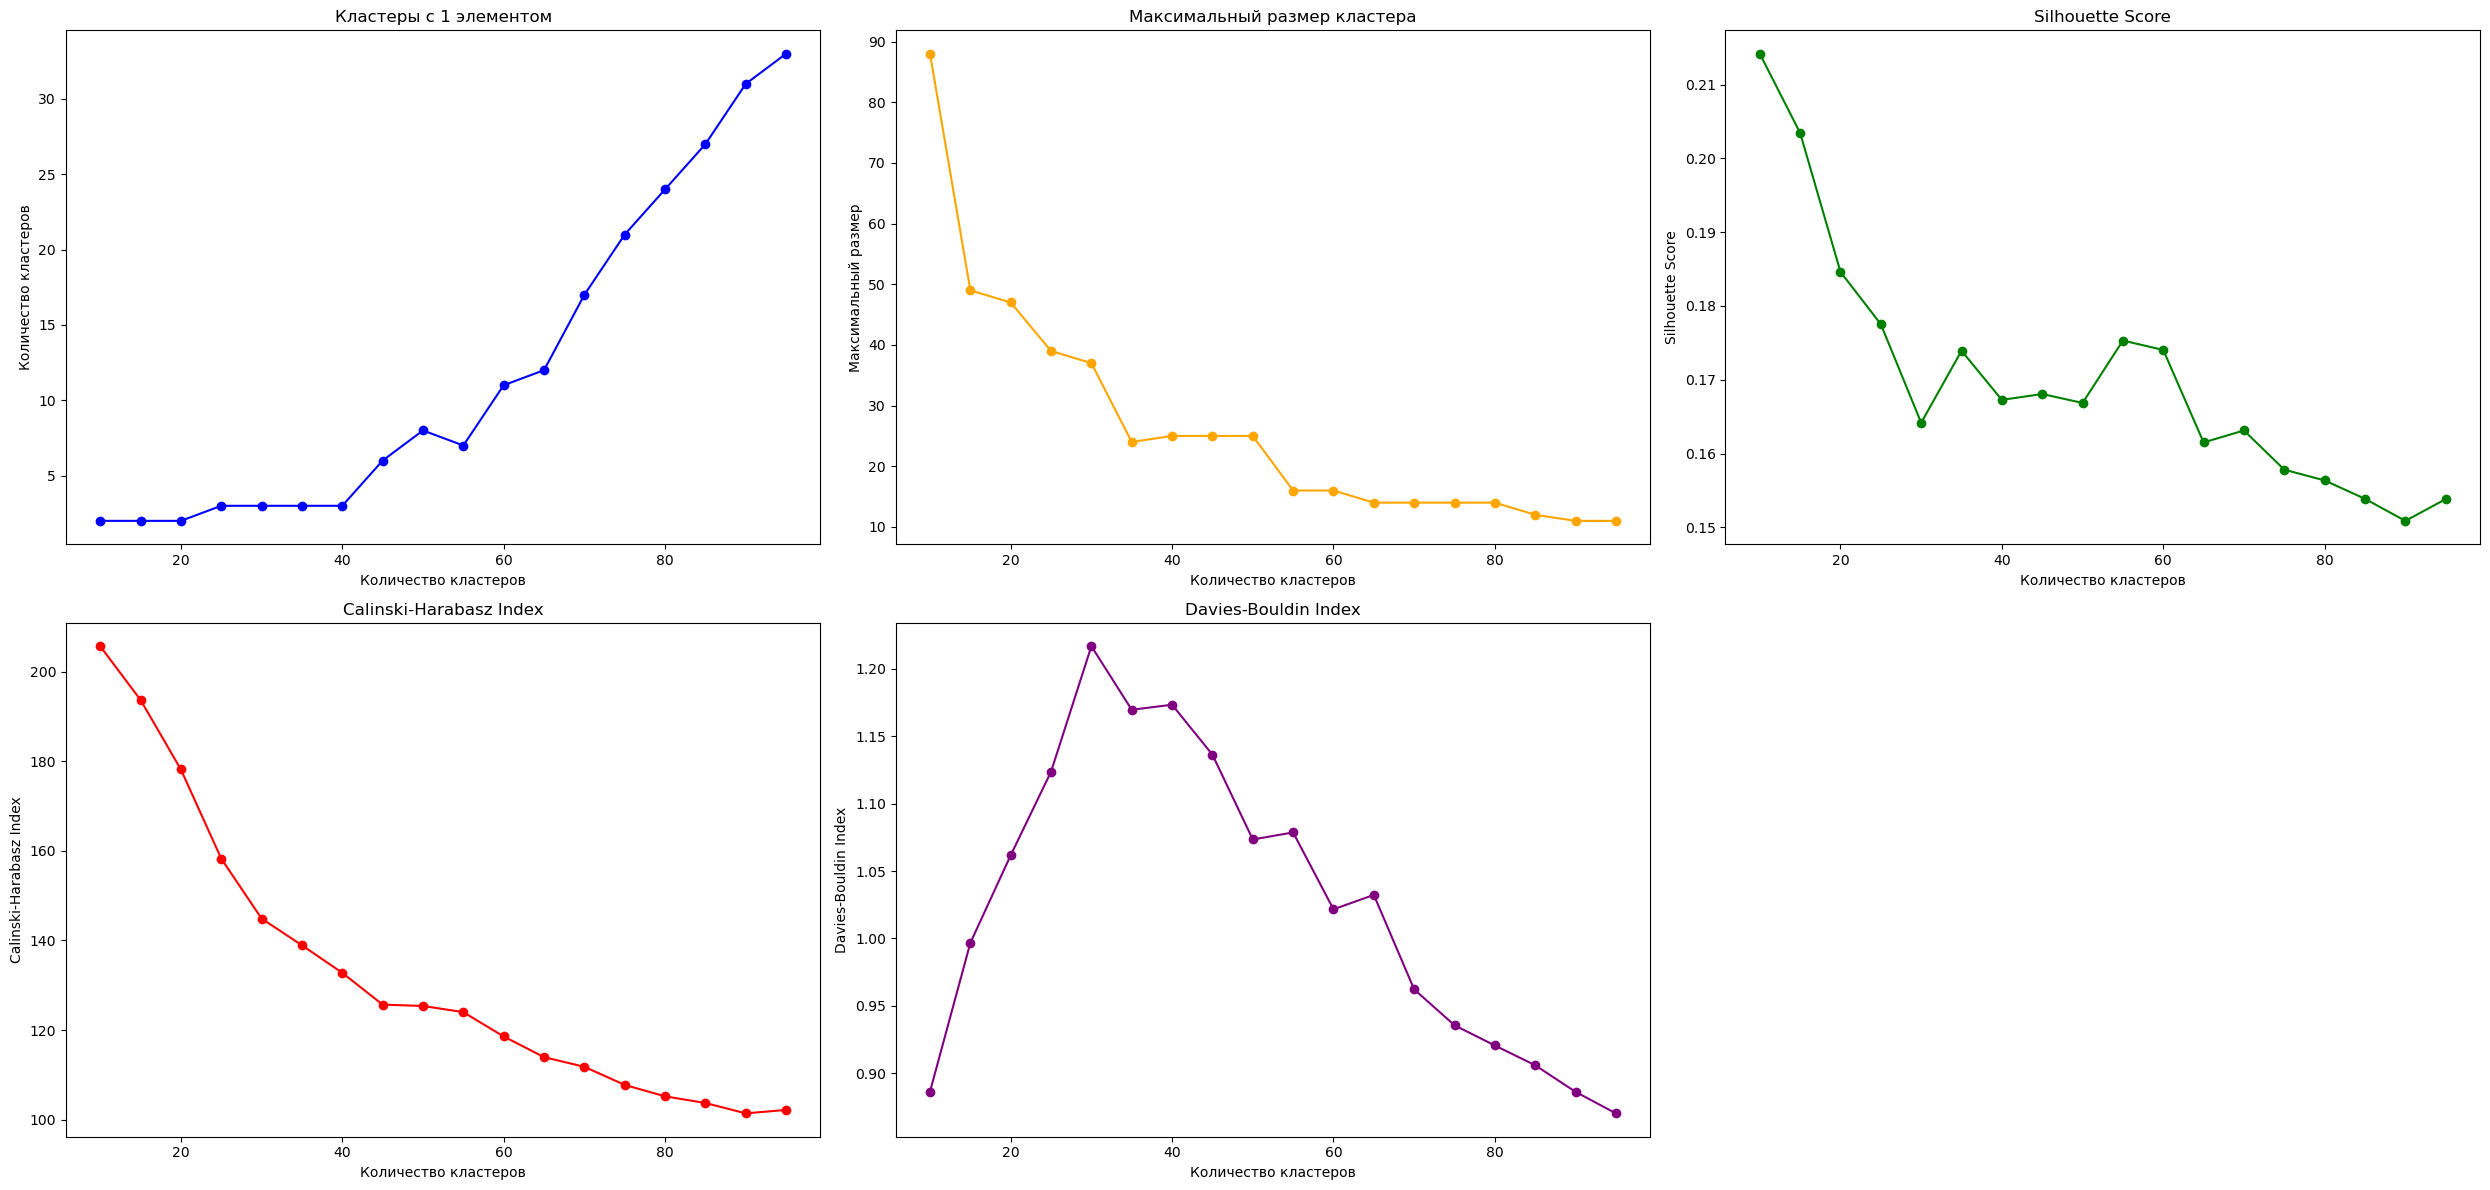

In [260]:
plt.figure(figsize=(25, 12))

plt.subplot(2, 3, 1)
plt.plot(n_clusters_range, single_item_clusters_list, marker='o', color='blue')
plt.title('Кластеры с 1 элементом')
plt.xlabel('Количество кластеров')
plt.ylabel('Количество кластеров')

plt.subplot(2, 3, 2)
plt.plot(n_clusters_range, max_cluster_size_list, marker='o', color='orange')
plt.title('Максимальный размер кластера')
plt.xlabel('Количество кластеров')
plt.ylabel('Максимальный размер')

plt.subplot(2, 3, 3)
plt.plot(n_clusters_range, Silhouett, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')

plt.subplot(2, 3, 4)
plt.plot(n_clusters_range, Calinski_Harabas, marker='o', color='red')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Calinski-Harabasz Index')

plt.subplot(2, 3, 5)
plt.plot(n_clusters_range, Davies_Bouldin, marker='o', color='purple')
plt.title('Davies-Bouldin Index')
plt.xlabel('Количество кластеров')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

#### Вывод:
Векторизация + кластеризация справляется с тем чтобы найти похожие по содержанию статьи, но при использовании небольшого датасета результат получается хуже, чем при использовании 2000 статей.